In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def select_roi(image):
    print("Select ROI and press ENTER or SPACE. Press ESC to cancel.")
    roi = cv2.selectROI("Select ROI", image, fromCenter=False, showCrosshair=True)
    cv2.destroyWindow("Select ROI")
    x, y, w, h = roi
    return x, y, x + w, y + h  # (x_min, y_min, x_max, y_max)
def auto_detect_substrate_roi(image, hough_thresh=50, min_line_len=100, margin_frac=0.55):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 30,100)
    plt.imshow(edges, cmap='gray')
    plt.title("Canny Edges")
    plt.axis('off')
    plt.show()
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=hough_thresh,
                            minLineLength=min_line_len, maxLineGap=20)
    h, w = image.shape[:2]
    top_lines = []
    bottom_lines = []

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            if abs(y2 - y1) < 10:  # horizontal line
                y_avg = (y1 + y2) // 2
                if y_avg < h * margin_frac:
                    top_lines.append(y_avg)
                elif y_avg > h * (1 - margin_frac):
                    bottom_lines.append(y_avg)

    if not top_lines or not bottom_lines:
        print("Failed to detect substrate lines.")
        return None
    top_lines = [max(top_lines)]
    bottom_lines = [min(bottom_lines)]
    print("Top lines:", top_lines)
    print("Bottom lines:", bottom_lines)
    y_min = top_lines[0]
    y_max = bottom_lines[0]
    x_min = 5
    x_max = w-5

    return (x_min, y_min, x_max, y_max)
def draw_detected_substrate_roi(image, roi_coords):
    x_min, y_min, x_max, y_max = roi_coords
    img = image.copy()
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 255, 255), 2)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Auto-detected ROI from Substrates")
    plt.axis('off')
    plt.show()

def preprocess_image(image, blur_ksize=5, canny_thresh=(50, 150)):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (blur_ksize, blur_ksize), 0)
    edges = cv2.Canny(blurred, *canny_thresh)
    return edges

def find_largest_contour(edges):
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        return None
    return max(contours, key=cv2.contourArea)
def split_contour_top_bottom(contour, buffer_px=2):
    contour = contour.reshape(-1, 2)
    y_min = np.min(contour[:, 1])
    y_max = np.max(contour[:, 1])
    y_center = (y_min + y_max) / 2

    top = contour[contour[:, 1] < (y_center - buffer_px)]
    bottom = contour[contour[:, 1] > (y_center + buffer_px)]

    return top.reshape(-1, 1, 2), bottom.reshape(-1, 1, 2)

def split_contour_left_right(contour, buffer_px=2):
    contour = contour.reshape(-1, 2)
    print("Sample contour points (first 5):", contour[:5])  # debug line

    # Just to be explicit:
    xs = contour[:, 0]
    ys = contour[:, 1]

    x_min = np.min(xs)
    x_max = np.max(xs)
    x_center = (x_min + x_max) / 2

    # Filter based on x-coordinates
    left = contour[xs < (x_center - buffer_px)]
    right = contour[xs > (x_center + buffer_px)]

    print(f"Left points: {len(left)}, Right points: {len(right)}")  # debug line

    return left.reshape(-1, 1, 2), right.reshape(-1, 1, 2)


def fit_ellipse_to_contour(contour):
    return cv2.fitEllipse(contour) if len(contour) >= 5 else None

def draw_results_two_ellipses(image, contour, ellipse_left, ellipse_right):
    output = image.copy()
    cv2.drawContours(output, [contour], -1, (0, 255, 0), 1)
    if ellipse_left:
        cv2.ellipse(output, ellipse_left, (255, 0, 0), 2)
    if ellipse_right:
        cv2.ellipse(output, ellipse_right, (0, 0, 255), 2)
    plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    plt.title("Left and Right Fitted Ellipses")
    plt.axis('off')
    plt.show()

def process_droplet_image_with_roi(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print("Failed to load image.")
        return

    # Select ROI and crop
    x_min, y_min, x_max, y_max = select_roi(image)
    cropped = image[y_min:y_max, x_min:x_max]

    # Edge detection
    edges = preprocess_image(cropped)

    # Find and process contour
    contour = find_largest_contour(edges)
    if contour is None or len(contour) < 10:
        print("No valid contour found.")
        return

    left, right = split_contour_left_right(contour)
    ellipse_left = fit_ellipse_to_contour(left)
    ellipse_right = fit_ellipse_to_contour(right)

    draw_results_two_ellipses(cropped, contour, ellipse_left, ellipse_right)
def crop_left_right(image):
    h, w = image.shape[:2]
    mid = w // 2
    left = image[:, :mid]
    right = image[:, mid:]
    return left, right

def find_largest_contour(edges):
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    return max(contours, key=cv2.contourArea) if contours else None
def draw_results_on_full_image(full_image, roi_coords, contour_left, contour_right, ellipse_left, ellipse_right):
    x_min, y_min, x_max, y_max = roi_coords
    overlay = full_image.copy()

    # Shift contours and ellipses into full image coordinates
    if contour_left is not None:
        shifted_left = contour_left + np.array([[[x_min, y_min]]])
        cv2.drawContours(overlay, [shifted_left], -1, (0, 255, 0), 1)

    if ellipse_left:
        (xc, yc), (MA, ma), angle = ellipse_left
        shifted_ellipse_left = ((xc + x_min, yc + y_min), (MA, ma), angle)
        cv2.ellipse(overlay, shifted_ellipse_left, (255, 0, 0), 2)

    if contour_right is not None:
        shifted_right = contour_right + np.array([[[x_min, y_min]]])
        cv2.drawContours(overlay, [shifted_right], -1, (0, 255, 0), 1)

    if ellipse_right:
        (xc, yc), (MA, ma), angle = ellipse_right
        shifted_ellipse_right = ((xc + x_min, yc + y_min), (MA, ma), angle)
        cv2.ellipse(overlay, shifted_ellipse_right, (0, 0, 255), 2)

    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title("Fitted Ellipses on Full Image")
    plt.axis('off')
    plt.show()

def process_droplet_two_lobes(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print("Failed to load image.")
        return

    # ROI selection
    roi_coords = auto_detect_substrate_roi(image)
    if roi_coords is None:
        return
    x_min, y_min, x_max, y_max = roi_coords
    cropped = image[y_min:y_max, x_min:x_max]

    draw_detected_substrate_roi(image, roi_coords)

    # From your ROI selection
    top_y = y_min
    bottom_y = y_max

    # Split ROI into left and right
    left_img, right_img = crop_left_right(cropped)

    # Process left side
    edges_left = preprocess_image(left_img)
    contour_left = find_largest_contour(edges_left)
    ellipse_left = fit_ellipse_to_contour(contour_left) if contour_left is not None else None

    # Process right side
    edges_right = preprocess_image(right_img)
    contour_right = find_largest_contour(edges_right)
    ellipse_right = fit_ellipse_to_contour(contour_right) if contour_right is not None else None

    # Offset right ellipse by half-width to align on original image
    h, w = cropped.shape[:2]
    if ellipse_right:
        (xc, yc), (MA, ma), angle = ellipse_right
        ellipse_right = ((xc + w // 2, yc), (MA, ma), angle)
        contour_right = contour_right + np.array([[[w // 2, 0]]])

    # Combine for visualization
    all_contours = []
    if contour_left is not None:
        all_contours.append(contour_left)
    if contour_right is not None:
        all_contours.append(contour_right)

    # draw_results_on_full_image(image, (x_min, y_min, x_max, y_max), contour_left, contour_right, ellipse_left, ellipse_right)
    return ellipse_left, ellipse_right, (x_min, y_min, x_max, y_max), image, cropped

def ellipse_to_points(center, axes, angle_deg, num_points=360):
    cx, cy = center
    a, b = axes[0] / 2, axes[1] / 2  # major and minor radii
    theta = np.deg2rad(angle_deg)

    t = np.linspace(0, 2 * np.pi, num_points)
    cos_angle = np.cos(theta)
    sin_angle = np.sin(theta)

    x = a * np.cos(t)
    y = b * np.sin(t)

    x_rot = cos_angle * x - sin_angle * y + cx
    y_rot = sin_angle * x + cos_angle * y + cy

    return np.stack((x_rot, y_rot), axis=-1)  # shape: (N, 2)

def find_contact_point_on_line(points, line_y, tolerance=2):
    # Find points near the horizontal line y = line_y
    dists = np.abs(points[:, 1] - line_y)
    near_line = np.where(dists < tolerance)[0]
    if len(near_line) == 0:
        return None
    closest_idx = near_line[np.argmin(np.abs(dists[near_line]))]
    return closest_idx, points[closest_idx]
def contact_angle_at_index(points, index, side='left', label='top'):
    if index <= 0 or index >= len(points) - 1:
        return None
    p1 = points[index - 1]
    p2 = points[index + 1]
    dx = p2[0] - p1[0]
    dy = p2[1] - p1[1]
    angle_rad = np.arctan2(np.abs(dy), np.abs(dx))
    angle_deg = np.rad2deg(angle_rad)
    print(f"Contact angle at index {index} ({label}): {angle_deg:.2f} degrees")
    # Flip convention for left side
    if side == 'left' and label == 'top' or side == 'right' and label == 'bottom':
        angle_deg = -angle_deg
    return angle_deg
def find_contact_point_on_line_half(points, line_y, side='right', tolerance=5):
    # Get center x to split
    center_x = np.mean(points[:, 0])
    if side == 'right':
        relevant_points = points[points[:, 0] > center_x]
    else:
        relevant_points = points[points[:, 0] < center_x]

    dists = np.abs(relevant_points[:, 1] - line_y)
    close_indices = np.where(dists < tolerance)[0]
    if len(close_indices) == 0:
        return None
    best_idx = close_indices[np.argmin(dists[close_indices])]
    return best_idx, relevant_points[best_idx]

def extract_all_contact_angles(ellipse, roi_y_top, roi_y_bottom, side='left'):
    if ellipse is None:
        return {}

    center, axes, angle = ellipse
    points = ellipse_to_points(center, axes, angle)

    result = {}

    for label, line_y in [('top', roi_y_top), ('bottom', roi_y_bottom)]:
        side_selector = 'right' if side == 'left' else 'left'  # inward-facing side
        idx, pt = find_contact_point_on_line_half(points, line_y, side_selector)
        if pt is not None:
            ang = contact_angle_at_index(points, idx, side, label)
            result[label] = {'point': pt, 'angle_deg': ang}
        else:
            result[label] = {'point': None, 'angle_deg': None}

    return result
def draw_debug_overlay(full_image, roi_coords, ellipse_left=None, ellipse_right=None, 
                        contacts_left=None, contacts_right=None):
    x_min, y_min, x_max, y_max = roi_coords
    img = full_image.copy()

    # Draw ROI boundary (optional)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 255, 255), 1) #color: yellow

    # Draw substrate lines
    cv2.line(img, (x_min, y_min), (x_max, y_min), (255, 0, 255), 1)  # Top line, color: magenta
    cv2.line(img, (x_min, y_max), (x_max, y_max), (255, 0, 255), 1)  # Bottom line

    # Draw ellipses
    if ellipse_left:
        (xc, yc), (MA, ma), angle = ellipse_left
        shifted = ((xc + x_min, yc + y_min), (MA, ma), angle)
        cv2.ellipse(img, shifted, (0, 0, 255), 2)
    if ellipse_right:
        (xc, yc), (MA, ma), angle = ellipse_right
        shifted = ((xc + x_min, yc + y_min), (MA, ma), angle)
        cv2.ellipse(img, shifted, (0, 255, 0), 2)

    # Draw contact points
    for contacts, color in [(contacts_left, (0, 0, 255)), (contacts_right, (0, 255, 0))]:
        if contacts:
            for pos in ['top', 'bottom']:
                pt = contacts[pos]['point']
                if pt is not None:
                    shifted_pt = (int(pt[0] + x_min), int(pt[1] + y_min))
                    cv2.circle(img, shifted_pt, 5, color, -1)

    # Show
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Ellipses, Contact Points, and Substrate Lines")
    plt.axis('off')
    plt.show()



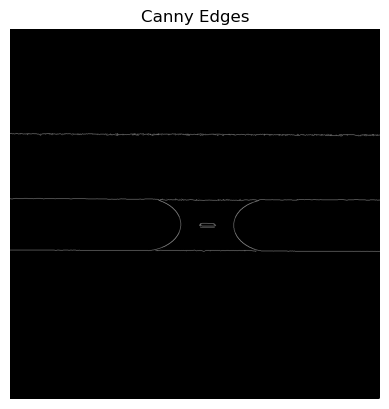

Top lines: [562]
Bottom lines: [726]


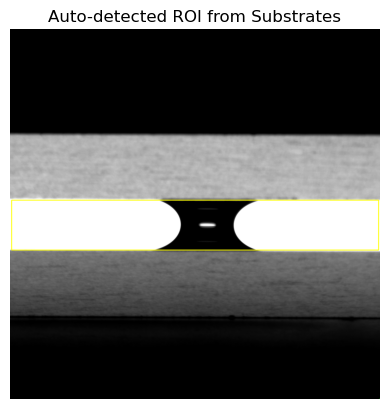

In [2]:
import tkinter as tk
from tkinter import filedialog
root = tk.Tk()
root.withdraw()  # Hide the root window
root.attributes('-topmost', True)  # Keep the file dialog on top
# Replace with your image path
image_path = filedialog.askopenfilename(title="Select a droplet image", filetypes=[("Image files", "*.jpg;*.jpeg;*.png")])
if image_path:
    ellipse_left, ellipse_right, (x_min, y_min, x_max, y_max), image, cropped =process_droplet_two_lobes(image_path)

Contact angle at index 21 (top): 16.11 degrees
Contact angle at index 165 (bottom): 10.28 degrees
Contact angle at index 165 (top): 9.73 degrees
Contact angle at index 21 (bottom): 16.43 degrees


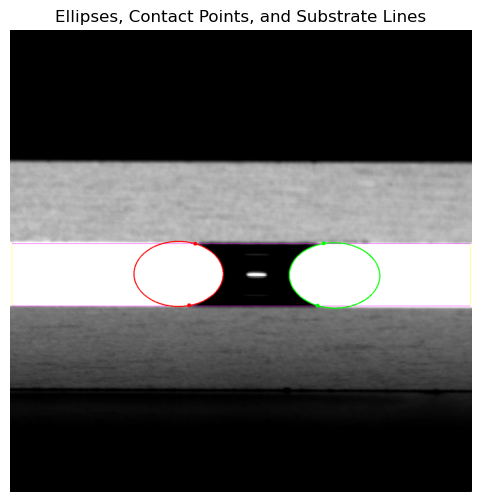

Left-top contact angle: -16.11°
Right-top contact angle: 9.73°
Left-bottom contact angle: 10.28°
Right-bottom contact angle: -16.43°


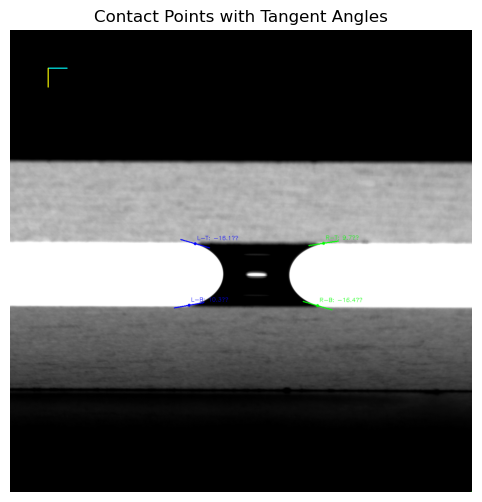

In [3]:
roi_y_top = 0
roi_y_bottom = cropped.shape[0] - 1


left_contacts = extract_all_contact_angles(ellipse_left, roi_y_top, roi_y_bottom, side='left')
right_contacts = extract_all_contact_angles(ellipse_right, roi_y_top, roi_y_bottom, side='right')
draw_debug_overlay(image, (x_min, y_min, x_max, y_max), ellipse_left, ellipse_right, left_contacts, right_contacts)
for pos in ['top', 'bottom']:
    print(f"Left-{pos} contact angle: {left_contacts[pos]['angle_deg']:.2f}°")
    print(f"Right-{pos} contact angle: {right_contacts[pos]['angle_deg']:.2f}°")

def shift_point_to_full_image(pt, roi_origin, half_width_offset=0):
    x_shift = roi_origin[0] + half_width_offset
    y_shift = roi_origin[1]
    return np.array([pt[0] + x_shift, pt[1] + y_shift])

def draw_contact_angle_debug(full_image, contact, roi_origin, color, half_width_offset=0, label=""):
    img = full_image.copy()

    pt = contact['point']
    angle = contact['angle_deg']
    if pt is None or angle is None:
        return img

    # Shift contact point to full image
    pt_full = shift_point_to_full_image(pt, roi_origin, half_width_offset)
    x0, y0 = int(pt_full[0]), int(pt_full[1])

    # Draw point
    cv2.circle(img, (x0, y0), 4, color, -1)

    # Compute tangent vector
    length = 40  # length of tangent line

    angle_rad = np.deg2rad(angle)
    dx = int(length * np.cos(angle_rad))
    dy = -int(length * np.sin(angle_rad))

    # Tangent line
    pt1 = (x0 - dx, y0 - dy)
    pt2 = (x0 + dx, y0 + dy)
    cv2.line(img, pt1, pt2, color, 2)

    # Annotate angle
    text_pos = (x0 + 5, y0 - 10)
    cv2.putText(img, f"{label}{angle:.1f}°", text_pos, cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    return img

img = image.copy()
half_width = (x_max - x_min) // 2
# Left top/bottom
img = draw_contact_angle_debug(img, left_contacts['top'], (x_min, y_min), (255, 0, 0), 0, "L-T: ")
img = draw_contact_angle_debug(img, left_contacts['bottom'], (x_min, y_min), (255, 0, 0), 0, "L-B: ")

# Right top/bottom
img = draw_contact_angle_debug(img, right_contacts['top'], (x_min, y_min), (0, 255, 0), 0, "R-T: ")
img = draw_contact_angle_debug(img, right_contacts['bottom'], (x_min, y_min), (0, 255, 0), 0, "R-B: ")
cv2.line(img, (100, 100), (100 + 50, 100), (255, 255, 0), 2)  # should go right
cv2.line(img, (100, 100), (100, 100 + 50), (0, 255, 255), 2)  # should go down

plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Contact Points with Tangent Angles")
plt.axis('off')
plt.show()